In [266]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda, concatenate
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import argparse
import os

In [267]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, img_size, img_size, 1])
x_test = np.reshape(x_test, [-1, img_size, img_size, 1])
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [268]:
print(f"x_train.shape: {x_train.shape}")
print(f"img_size: {img_size}")

x_train.shape: (60000, 28, 28, 1)
img_size: 28


In [269]:
num_labels = len(np.unique(y_train))
print(f"num_labels: {num_labels}")

num_labels: 10


In [270]:
def sampling(args):
    z_mean, z_log_variance = args
    batch_size = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]

    epsilon = K.random_normal(shape=(batch_size, dim))

    return z_mean + K.exp(0.5 * z_log_variance) * epsilon

In [271]:
input_shape = (img_size, img_size, 1)
label_shape = (num_labels,)
batch_size = 128
kernel_size = 3
layer_fiters = [16, 32]
latent_dim = 2
epochs = 30

Encoder

In [272]:
'''
Author: SessyoinKirin
Date: 2025-09-15 09:24:49
LastEditors: SessyoinKirin
LastEditTime: 2025-09-15 11:04:19
FilePath: \CVAE\testeInicialCVAE.ipynb
Description: 

Copyright (c) 2025 by SessyoinKirin, All Rights Reserved. 
'''
inputs = Input(shape=(input_shape), name='encoder_input') #(28*28*1)
y_label = Input(shape=label_shape, name='label_info') #(10,)
x = Dense(img_size * img_size)(y_label) #(784,)
x = Reshape((img_size, img_size, 1))(x) #(28*28*1)

x = concatenate([inputs, x]) #(28*28*2)

for filter_size in layer_fiters:
    x = Conv2D(filters= filter_size, 
               kernel_size = kernel_size,
               activation = 'relu',
               strides = 2,
               padding = 'same')(x)
    
conv_latent_shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_variance")(x)

z= Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder_model = Model([inputs, y_label], [z_mean, z_log_var, z], name="encoder_model")

<>:6: SyntaxWarning: invalid escape sequence '\C'
<>:6: SyntaxWarning: invalid escape sequence '\C'
C:\Users\chena\AppData\Local\Temp\ipykernel_14624\2076395065.py:6: SyntaxWarning: invalid escape sequence '\C'
  FilePath: \CVAE\testeInicialCVAE.ipynb


In [273]:
plot_model(encoder_model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [274]:
layer_fiters

[16, 32]

Decoder

In [275]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = concatenate([latent_inputs, y_label])

x = Dense(conv_latent_shape[1] * conv_latent_shape[2] * conv_latent_shape[3])(x)
x = Reshape((conv_latent_shape[1], conv_latent_shape[2], conv_latent_shape[3]))(x)

for filter_size in layer_fiters[::-1]:
    x = Conv2DTranspose(filters = filter_size,
                        kernel_size = kernel_size,
                        activation = 'relu',
                        strides = 2,
                        padding = 'same')(x)
    
output = Conv2DTranspose(filters = 1,
                         kernel_size = kernel_size,
                         activation = 'sigmoid',
                         padding = 'same',
                         name = 'decoder_output')(x)

decoder_model = Model([latent_inputs, y_label], output, name="decoder_model")

In [276]:
plot_model(decoder_model, show_shapes= True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


VAE

In [277]:
f = encoder_model([inputs, y_label])[2]
intermediate_output = decoder_model([f, y_label])

cvae = Model([inputs, y_label], intermediate_output, name='cvae')

# intermdiate_output = decoder_model(encoder_model([inputs, y_label])[2],y_label)
# cvae = Model([inputs, y_label], intermdiate_output, name='cvae')

losses

In [278]:
from keras import ops

# # Usar ops.reshape em vez de K.flatten
# reconstruction_loss = mse(ops.reshape(inputs, (-1,)), ops.reshape(intermediate_output, (-1,)))
# reconstruction_loss *= img_size * img_size

# # Usar ops do Keras 3.x
# kl_loss = 1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var)
# kl_loss = ops.sum(kl_loss, axis=1)
# kl_loss = kl_loss * -0.5

# vae_loss = ops.mean(reconstruction_loss + kl_loss)

# cvae.add_loss(vae_loss)
# cvae.compile(optimizer='adam')

# # Defina a função de loss de forma correta para o Keras 3.x
# def vae_loss(y_true, y_pred):
#     # Recupere os tensores reais do contexto de treinamento
#     inputs = y_true  # y_true são os dummy targets, mas vamos ignorar
#     reconstruction = y_pred
    
#     # Calcule a reconstruction loss
#     reconstruction_loss = mse(ops.reshape(inputs, (-1,)), ops.reshape(reconstruction, (-1,)))
#     reconstruction_loss *= img_size * img_size
    
#     # Para KL loss, precisamos acessar z_mean e z_log_var de outra forma
#     # Vamos modificar o encoder para retornar também esses valores como parte do modelo
#     return reconstruction_loss

# REMOVA a loss personalizada e use binary_crossentropy
cvae.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

# Treine novamente
history = cvae.fit(
    [x_train, to_categorical(y_train)],
    x_train,  # Autoencoder - target = input
    epochs=10,
    batch_size=128,
    validation_data=([x_test, to_categorical(y_test)], x_test)
)

# Compile com a função de loss simplificada primeiro
# cvae.compile(optimizer='adam', loss=vae_loss)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 0.2444 - mse: 0.0607 - val_loss: 0.1914 - val_mse: 0.0435
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.1830 - mse: 0.0408 - val_loss: 0.1758 - val_mse: 0.0384
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.1725 - mse: 0.0371 - val_loss: 0.1696 - val_mse: 0.0362
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.1685 - mse: 0.0357 - val_loss: 0.1671 - val_mse: 0.0353
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.1664 - mse: 0.0350 - val_loss: 0.1657 - val_mse: 0.0348
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.1650 - mse: 0.0345 - val_loss: 0.1643 - val_mse: 0.0342
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.1639 - mse: 0.0341 - val_loss: 0.1639 - val_mse: 0.0341
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.1631 - mse: 0.0338 - val_loss: 0.1626 - val_mse: 0.0337
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 

In [279]:
# cvae.fit([x_train, to_categorical(y_train)],
#          epochs = epochs,
#          batch_size = batch_size,
#          validation_data = ([x_test, to_categorical(y_test)], None))


# Converta os labels para categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Fit com dados dummy
dummy_targets = np.zeros_like(x_train)
dummy_targets_val = np.zeros_like(x_test)

cvae.fit(
    [x_train, to_categorical(y_train)],
    dummy_targets,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([x_test, to_categorical(y_test)], dummy_targets_val)
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 8.7600e-04 - mse: 2.7139e-04 - val_loss: 1.8846e-06 - val_mse: 1.8277e-09
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 1.5523e-06 - mse: 1.4794e-09 - val_loss: 1.1611e-06 - val_mse: 4.5380e-10
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 2.7539e-07 - mse: 7.7906e-11 - val_loss: 3.1990e-08 - val_mse: 8.8730e-13
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 2.0735e-08 - mse: 3.7159e-13 - val_loss: 1.2317e-08 - val_mse: 1.2031e-13
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 9.8714e-09 - mse: 8.1658e-14 - val_loss: 6.9596e-09 - val_mse: 3.8515e-14
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 6.0677e-09 - mse: 3.1971e-14 - val_loss: 4.5798e-09 - val_mse: 1.6850e-14
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 4.1939e-09 - mse: 1.5878e-14 - val_loss: 3.2914e-09 - val_mse: 8.9900e-15
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms

In [280]:
def plot_imgs(imgs):
    _,axs = plt.subplots(5,5, figsize=(10,10))

    axs = axs.flatten()
    for img,ax in zip(imgs, axs):
        ax.imshow(img, cmap='gray')

    plt.show()

In [281]:
# Use mais amostras para garantir todas as classes
test_pred = cvae.predict([x_test[:10], to_categorical(y_test[:10])])
print("Prediction range:", test_pred.min(), test_pred.max())
print("Prediction mean:", test_pred.mean())

# Ou especifique o número de classes explicitamente
test_pred = cvae.predict([x_test[:1], to_categorical(y_test[:1], num_classes=10)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Prediction range: 0.0 8.4207805e-08
Prediction mean: 3.9081214e-11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


In [282]:
res = cvae.predict((x_test[:25], to_categorical(y_test[:25])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


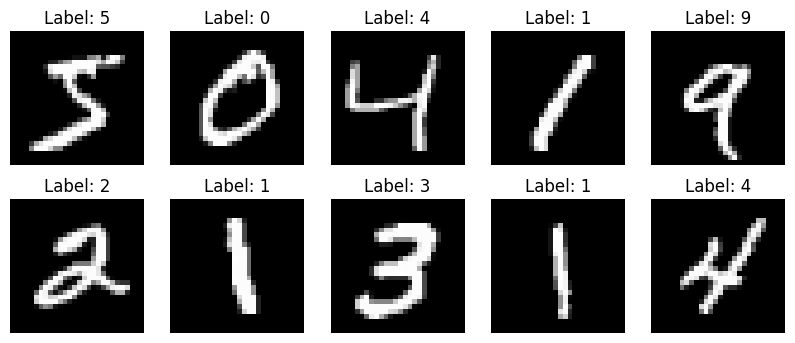

In [283]:
# Verifique algumas imagens originais
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.show()

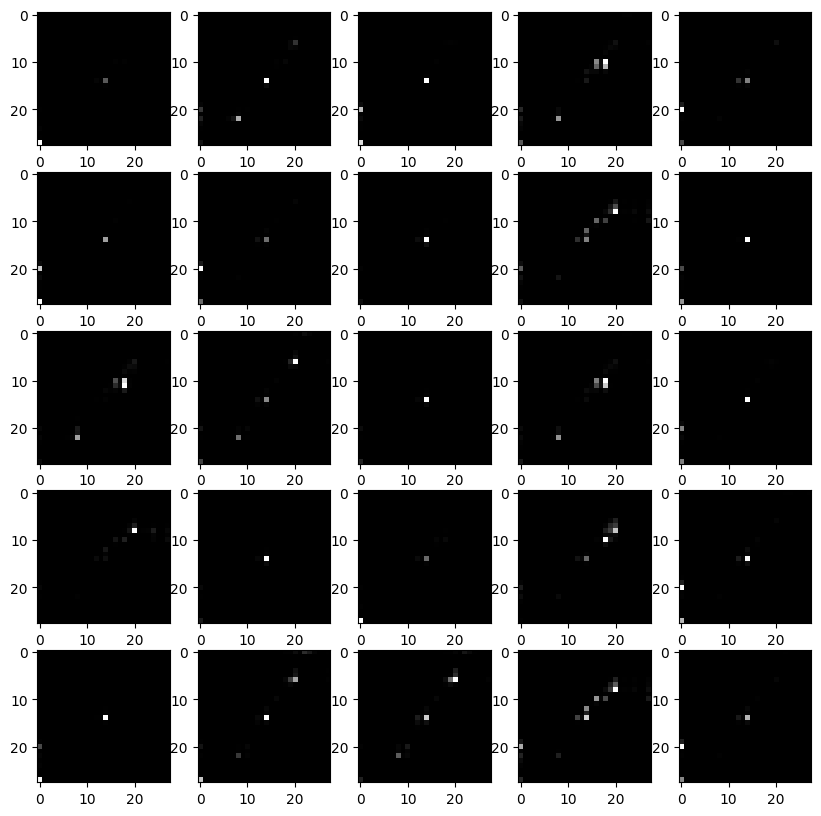

In [284]:
plot_imgs(res)